# Credit Score Classification with Supervised Learning

#### DTSA 5509: Introduction to Machine Learning: Supervised Learning

In this notebook, I'll import, explore, and clean a dataset, use it to classify a person's credit score into categories, examine the results, and reflect on key findings.

The full GitHub repo for this project can be found at https://github.com/23ccozad/credit-score-prediction.

First, I'll begin by importing the libraries needed to run this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


import re

### Project Topic (5 pts)

*Rubric: Is there a clear explanation of what this project is about? Does it state clearly which type of problem? E.g. type of learning and type of the task. Is the goal of the project clearly stated? E.g. why it's important, what goal the author wants to achieve, or wants to learn.*

**Goal**: This project aims to **predict a person's credit score as "poor", "standard", or "good"** based on a information about their financial history.

This is a **classification task**, since the output of the algorithms will be one of the three labels mentioned above.

More specifically, this will be **multiclass classification**, since there are more than two categories that samples can be labeled with.

I'll explore various **supervised learning** algorithms to complete this task, since I have a dataset that provides a credit score label for every sample. Supervised learning algorithms learn how to assign labels to samples based on patterns in the other features the dataset provides.

Why would someone want to predict credit score? There's a couple reasons:

*   Agencies that assign credit scores might want to routinely verify their credit scoring methodology is sound, and a machine learning algorithm trained on past data can provide a sanity check.
*   Sometimes when people check their credit score, it can go down a few points, just because they checked it. A machine learning algorithm that predicts credit scores can provide an estimate for people, without having to check their actual credit score and risking losing points.

Personally, I'm also interested in learning which features are most important in predicting credit score, and what I can potentially do to improve my own credit score.

### Data (5 pts)

*Rubric: Is the data source properly cited in APA and described from/how it was
gathered? (including links, brief explanations) Is the data description explained properly? The data description should include the data size.*

*For tabulated data: number of samples/rows, number of features/columns, bytesize if a huge file, data type of each feature (or just a summary if too many features- e.g. 10 categorical, 20 numeric features), description of features (at least some key features if too many), whether the data is multi-table form or gathered from multiple data source*

APA citation for dataset:

> Paris, R. (2022). Credit score classification [Data set]. Kaggle. https://www.kaggle.com/datasets/parisrohan/credit-score-classification



Most Kaggle datasets come with metadata that describes how the data was collected and who it comes from. However, this dataset doesn't describe how it was collected or by whom. If I had to guess, the data comes from a credit agency or lender. It was probably also anonymized in some way to prevent protected personal information from being revealed in the data.

First, I'll import the data so I can begin exploring and describing it.

In [2]:
data_filepath = "/content/drive/MyDrive/CU Boulder Data Science/DTSA 5509 - Introduction to Machine Learning: Supervised Learning/Final Project/train.csv"
data = pd.read_csv(data_filepath)

<ipython-input-2-212750e4e285>:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_filepath)


The dataset I'll train with it a single table that has 100,000 samples and 28 features.

In [3]:
data.shape

(100000, 28)

Each sample represents an individual and their financial history, and is labeled with a credit score. Let's take a look at the data type of each feature:

In [4]:
data.dtypes

,0
ID,object
Customer_ID,object
Month,object
Name,object
Age,object
SSN,object
Occupation,object
Annual_Income,object
Monthly_Inhand_Salary,float64
Num_Bank_Accounts,int64


According to documentation for the dataset, there a short descriptions available for each feature:

*   ID: Represents a unique identification of an entry
*   Customer_ID: Represents a unique identification of a person
*   Month: Represents the month of the year
*   Name: Represents the name of a person
*   Age: Represents the age of the person
*   SSN: Represents the social security number of a person
*   Occupation: Represents the occupation of the person
*   Annual_Income: Represents the annual income of the person
*   Monthly_Inhand_Salary: Represents the monthly base salary of a person
*   Num_Bank_Accounts: Represents the number of bank accounts a person holds
*   Num_Credit_Card: Represents the number of other credit cards held by a person
*   Interest_Rate: Represents the interest rate on credit card
*   Num_of_Loan: Represents the number of loans taken from the bank
*   Type_of_Loan: Represents the types of loan taken by a person
*   Delay_from_due_date: Represents the average number of days delayed from the payment date
*   Num_of_Delayed_Payment: Represents the average number of payments delayed by a person
*   Changed_Credit_Limit: Represents the percentage change in credit card limit
*   Num_Credit_Inquiries: Represents the number of credit card inquiries
*   Credit_Mix: Represents the classification of the mix of credits
*   Outstanding_Debt: Represents the remaining debt to be paid (in USD)
*   Credit_Utilization_Ratio: Represents the utilization ratio of credit card
*   Credit_History_Age: Represents the age of credit history of the person
*   Payment_of_Min_Amount: Represents whether only the minimum amount was paid by the person
*   Total_EMI_per_month: Represents the monthly EMI payments (in USD)
*   Amount_invested_monthly: Represents the monthly amount invested by the customer (in USD)
*   Payment_Behaviour: Represents the payment behavior of the customer (in USD)
*   Monthly_Balance: Represents the monthly balance amount of the customer (in USD)
*   Credit_Score: Represents the bracket of credit score (Poor, Standard, Good)

### Data Cleaning (10 pts)

*Rubric: Does it include clear explanations on how and why a cleaning is performed? Does it have conclusions or discussions? (e.g. the data cleaning summary, findings, discussing foreseen difficulties and/or analysis strategy) Does it have proper visualizations? (for tabulated data, meeting the benchmark for moderate data cleaning could include: data type munging, drop NA, impute missing values, check for imbalance, look for any data-specific potential problems, and address issues found.)*

#### Drop irrelevant features

Recall that these are all of the columns in the dataset:

In [5]:
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

Based on the descriptions of these columns, most look like they could potentially be helpful in predicting credit score. I'm doubtful that ID, Customer_ID, Month, Name, or SSN would be helpful, since most of these are just identifiers of some kind, rather than useful financial information.

Let's take a closer look at these.

In [6]:
data['ID'].unique()

array(['0x1602', '0x1603', '0x1604', ..., '0x25feb', '0x25fec', '0x25fed'],
      dtype=object)

In [7]:
data['Customer_ID'].unique()

array(['CUS_0xd40', 'CUS_0x21b1', 'CUS_0x2dbc', ..., 'CUS_0xaf61',
       'CUS_0x8600', 'CUS_0x942c'], dtype=object)

In [8]:
data['Name'].unique()

array(['Aaron Maashoh', nan, 'Rick Rothackerj', ..., 'Chris Wickhamm',
       'Sarah McBridec', 'Nicks'], dtype=object)

In [9]:
data['SSN'].unique()

array(['821-00-0265', '#F%$D@*&8', '004-07-5839', ..., '133-16-7738',
       '031-35-0942', '078-73-5990'], dtype=object)

In [10]:
data['Month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

Based on the values in these columns, I don't find any of them to be particularly useful in predicting credit score.

An argument could be made that credit scores may be biased by race or gender, and that first or last names could be used to help understand those patterns, but an analysis of that depth is beyond the scope of the project.

With regard to "month" as a column, I'm confused as to why only January through August are listed. This means the months of September though December are not found anywhere in the column. In addition to the fact that a "month" column doesn't seem predictive of credit scores in the first place, I'll opt to drop this column.

ID, Customer_ID, and SSN are just identifiers, and should have no bearing on someone's credit score. I'll drop these columns as well.

In [11]:
data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN', 'Month'], inplace=True)

I'll verify that the columns have been dropped by printing out all of the columns in the table again.

In [12]:
data.columns

Index(['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

#### Correct feature data types

Based on the descriptions of each column, I created a dictionary with what data type each column should be:

In [13]:
feature_types = {'Age': 'int',
                 'Occupation': 'string',
                 'Annual_Income': 'float',
                 'Monthly_Inhand_Salary': 'float',
                 'Num_Bank_Accounts': 'int',
                 'Num_Credit_Card': 'int',
                 'Interest_Rate': 'float',
                 'Num_of_Loan': 'int',
                 'Type_of_Loan': 'string',
                 'Delay_from_due_date': 'int',
                 'Num_of_Delayed_Payment': 'Int64',  # Capital "I" Int64 allows NaN values
                 'Changed_Credit_Limit': 'Float64',  # Capital "F" allows NaN values
                 'Num_Credit_Inquiries': 'Int64',    # Capital "I" allows NaN values
                 'Credit_Mix': 'string',
                 'Outstanding_Debt': 'float',
                 'Credit_Utilization_Ratio': 'float',
                 'Credit_History_Age': 'float',
                 'Payment_of_Min_Amount': 'bool',
                 'Total_EMI_per_month': 'float',
                 'Amount_invested_monthly': 'float',
                 'Payment_Behaviour': 'string',
                 'Monthly_Balance': 'float',
                 'Credit_Score': 'string'}

Unfortunately, many columns are not in the correct format, and need some additional work before they can be converted.

In [14]:
# Remove underscores from the "Age" column (e.g. "28_" is not a valid age)
data['Age'] = data['Age'].str.replace('_', '', regex=False)

# Remove underscores from the "Annual_Income" column (e.g. "34847.84_" is not a valid income)
data['Annual_Income'] = data['Annual_Income'].str.replace('_', '', regex=False)

# Remove underscores from the "Num_of_Loan" column (e.g. "0_" is not a valid number of loans)
data['Num_of_Loan'] = data['Num_of_Loan'].str.replace('_', '', regex=False)

# Remove underscores from the "Num_of_Delayed_Payment" column (e.g. "8_" is not a valid number of delayed payments)
data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].str.replace('_', '', regex=False)

# Remove underscores from the "Changed_Credit_Limit" column (e.g. "_" is not a valid credit limit change)
data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].str.replace('_', '', regex=False)
data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].replace(r'^\s*$', np.nan, regex=True)

# Remove underscores from the "Outstanding_Debt" column (e.g. "1328.93_" is not a valid amount)
data['Outstanding_Debt'] = data['Outstanding_Debt'].str.replace('_', '', regex=False)

# Remove underscores from the "Amount_invested_monthly" column (e.g. "__10000__" is not a valid amount)
data['Amount_invested_monthly'] = data['Amount_invested_monthly'].str.replace('_', '', regex=False)

# Remove underscores from the "Monthly_Balance" column (e.g. "__10000__" is not a valid amount)
data['Monthly_Balance'] = data['Monthly_Balance'].str.replace('_', '', regex=False)

In [15]:
# Convert "Credit_History_Age" column from a string (e.g. "22 Years and 1 Months") to a float (e.g. 22.08)
def parse_age(exp_str):
    if type(exp_str) != str:
        return np.nan
    match = re.match(r'(\d+)\s+Years\s+and\s+(\d+)\s+Months', exp_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years + months / 12
    return np.nan

data['Credit_History_Age'] = data['Credit_History_Age'].apply(parse_age)

In [16]:
# Perform the data type conversions
data = data.astype(feature_types)

The features are now the correct data types!

#### Handle missing values

In [17]:
data.isna().mean() * 100

,0
Age,0.000
Occupation,0.000
Annual_Income,0.000
Monthly_Inhand_Salary,15.002
Num_Bank_Accounts,0.000
Num_Credit_Card,0.000
Interest_Rate,0.000
Num_of_Loan,0.000
Type_of_Loan,11.408
Delay_from_due_date,0.000


I see that there are a few columns with missing values:
* Monthly_Inhand_Salary (15% missing)
* Type_of_Loan (11% missing)
* Num_of_Delayed_Payment (7% missing)
* Changed_Credit_Limit (2% missing)
* Num_Credit_Inquiries (2% missing)
* Credit_History_Age (9% missing)
* Amount_invested_monthly (4% missing)
* Monthly_Balance (3% missing)

For most of these columns, the number of missing values are relatively small, so I will opt to impute them with the median value.

In [18]:
for col in ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
            'Num_Credit_Inquiries', 'Credit_History_Age', 'Amount_invested_monthly', 'Monthly_Balance']:
    data[col] = data[col].fillna(data[col].median())

I also want to make sure we remove nonsensical or missing values from the categorical features as well. I'll begin by exploring the values appearing in those columns.

First, let's look at Occupation:

In [19]:
#Occupation, Credit_Mix, Payment_Behaviour, Credit_Score
data['Occupation'].value_counts()

,count
Occupation,
_______,7062
Lawyer,6575
Architect,6355
Engineer,6350
Scientist,6299
Mechanic,6291
Accountant,6271
Developer,6235
Media_Manager,6232


Over six thousand rows have a set of underscores as the occupation, probably indicating those are missing values. Since this is a categorical feature, we cannot impute with the median. We could impute with the mode, but I think that would skew the data too much in an inaccurate way. Therefore, I'll elect to drop those rows with a blank occupation.

In [20]:
data = data[data['Occupation'] != '_______']

Next, looking at Credit_Mix, we have a large number of rows with just an underscore. This also probably represents missing data. I don't think there's a good way to impute that many values. However, I think a category called something like "Unknown" would be accpetable. So, I just relabel these missing values and keep them in place.

In [21]:
data['Credit_Mix'].value_counts()

,count
Credit_Mix,
Standard,33916
Good,22618
_,18774
Bad,17630


In [22]:
data.loc[:, 'Occupation'] = data['Occupation'].replace('_', 'Unknown')

Similarly, we have a fairly deceny chunk of values in Payment_Behaviour that are nonsense, probably representing missing values. I rename those to "Unknown" as well.

In [23]:
data['Payment_Behaviour'].value_counts()

,count
Payment_Behaviour,
Low_spent_Small_value_payments,23720
High_spent_Medium_value_payments,16301
Low_spent_Medium_value_payments,12882
High_spent_Large_value_payments,12767
High_spent_Small_value_payments,10524
Low_spent_Large_value_payments,9658
!@9#%8,7086


In [24]:
data.loc[:, 'Payment_Behaviour'] = data['Payment_Behaviour'].replace('!@9#%8', 'Unknown')

Lastly, our target variable, Credit_Score, has no missing or nonsense values, which is great!

In [25]:
data['Credit_Score'].value_counts()

,count
Credit_Score,
Standard,49386
Poor,26967
Good,16585


I still need to address the missing values in Type_of_Loan, which we wouldn't want to impute with the median, since this column is actually composed of several values, such as:

In [26]:
data['Type_of_Loan'][0]

'Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'

This column really should be seperated so each type of loan is it's own column. I'll first use some code to figure out all the different types of loans that exist in this column.

In [27]:
# Convert loans from comma-seperated to a list in each row
data['Type_of_Loan_cleaned'] = data['Type_of_Loan'].str.replace(' and ', ', ', regex=False)
data['Loan_List'] = data['Type_of_Loan_cleaned'].apply(lambda x: [i.strip() for i in x.split(',')] if pd.notna(x) else [])

# Create new boolean columns for each type of loan
all_loans = sorted({loan for sublist in data['Loan_List'] for loan in sublist})
for loan in all_loans:
    data[loan] = data['Loan_List'].apply(lambda x: loan in x)

# Drop non-sense columns created during the task
data = data.drop(columns=['', 'Not Specified'])

# Remove the columns that aren't needed anymore
data = data.drop(columns=['Type_of_Loan', 'Type_of_Loan_cleaned', 'Loan_List'])

Now we've separated each type of loan a person has into boolean columns. Missing values in the original loan type column translate into False values for all loan type columns. Here's a preview:

In [28]:
data.iloc[:10, -8:]

,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan
0,True,True,False,True,False,False,True,False
1,True,True,False,True,False,False,True,False
2,True,True,False,True,False,False,True,False
3,True,True,False,True,False,False,True,False
4,True,True,False,True,False,False,True,False
5,True,True,False,True,False,False,True,False
6,True,True,False,True,False,False,True,False
7,True,True,False,True,False,False,True,False
9,False,True,False,False,False,False,False,False
10,False,True,False,False,False,False,False,False


#### Handle duplicate samples

It's sometimes possible that rows in datasets are duplicates of each other, due to errors in data collection and data management. Let's check to see if there's any duplicate rows to examine further:

In [29]:
# Looks like we have zero duplicate rows
sum(data.duplicated())

0

#### Handle outliers

Let's take a look at the distribution of our features and see whether they have any outliers that need to be dropped.

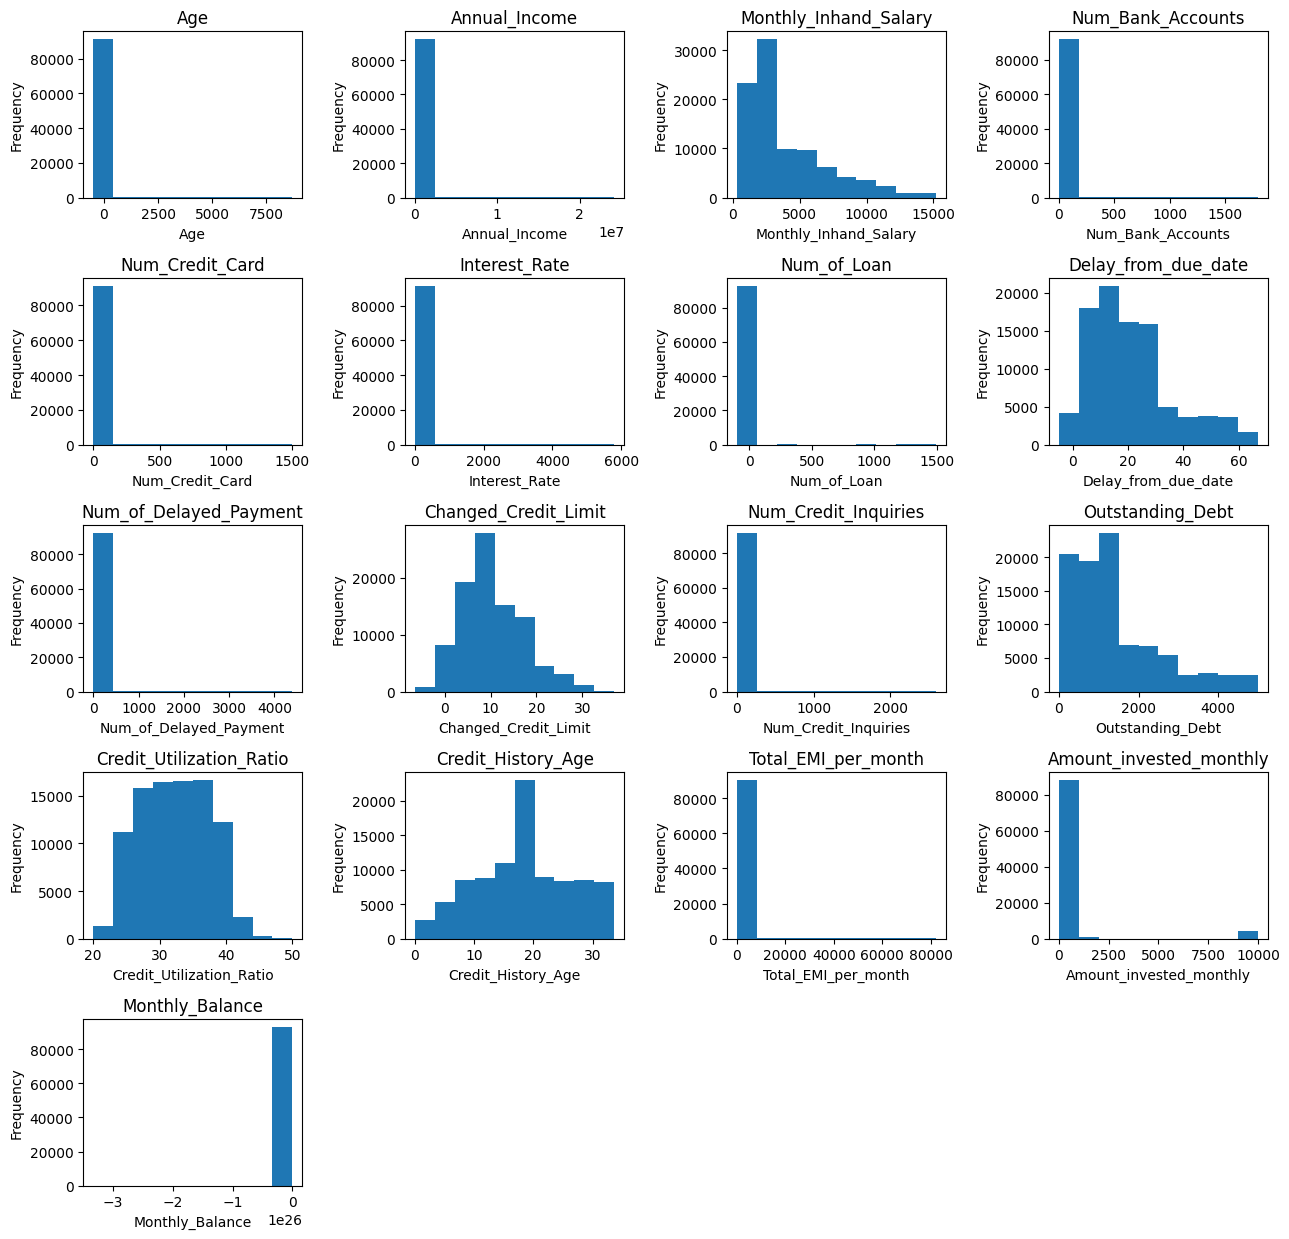

In [30]:
data_numeric = data.select_dtypes(include='number')

num_cols = data_numeric.shape[1]
ncols = 4
nrows = (num_cols + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 2.5 * nrows))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(data_numeric.columns):
    data_numeric[col].plot.hist(ax=axes[i], bins=10, title=col)
    axes[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Based on these plots, I'd want to take a closer look at Age, Annual_Income, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Num_of_Delayed_Payment, Num_Credit_Inquiries, Total_EMI_per_Month, and Amount_invested_monthly.

Those variables then to have heavily-skewed histograms, which may suggest they have erroneous outliers that I should drop.

First, looking at Age, the oldest person to ever live was 122 years old. I have to assume anyone listed over that age is an error. Here's a look at those values:

In [31]:
data[data['Age'] > 122].sort_values(by='Age')['Age']

,Age
3126,123
21236,124
19328,126
13203,134
24378,142
...,...
13372,8674
82335,8678
35557,8682
82739,8697


In [32]:
data = data[(data['Age'] <= 122) & (data['Age'] > 0)]

Annual_Income can have a more expansive set of values, and outliers would be expected for those who are very rich. Based on a quick look at the sorted dataframe below, the upper and lower few values of Annual_Income seem plausible.

In [33]:
data[data['Annual_Income'] > 0].sort_values(by='Annual_Income')['Annual_Income']

,Annual_Income
39676,7005.93
39678,7005.93
39677,7005.93
39673,7005.93
39674,7005.93
...,...
27262,24105369.00
14588,24160009.00
59059,24177153.00
7814,24188807.00


With regard to Num_Bank_Accounts, note that some rows show -1 for this feature. I'm going to assume -1 represents a missing value, so I'll drop these rows from the dataset.

In [34]:
data[data['Num_Bank_Accounts'] < 0]['Num_Bank_Accounts']

,Num_Bank_Accounts
30330,-1
30331,-1
30332,-1
30333,-1
30334,-1
30335,-1
43689,-1
43690,-1
43691,-1
43692,-1


In [35]:
data = data[data['Num_Bank_Accounts'] >= 0]

Looks like Num_Credit_Card doesn't have any negative values, so that's good!

In [36]:
data[data['Num_Credit_Card'] < 0]['Num_Credit_Card']

,Num_Credit_Card


Similarly, there are no negative interest rates as well.

In [37]:
data[data['Interest_Rate'] < 0]['Interest_Rate']

,Interest_Rate


Looks like we have some Num_of_Loan values that are below zero, so we'll go ahead and drop those. It doesn't make sense to have a negative number of loans, and since they're all -100, that may have been an indicators for a missing value in this column.

In [38]:
data[data['Num_of_Loan'] < 0]['Num_of_Loan']

,Num_of_Loan
31,-100
34,-100
39,-100
53,-100
61,-100
...,...
99859,-100
99876,-100
99902,-100
99969,-100


In [39]:
data = data[data['Num_of_Loan'] >= 0]

We also see several negative values for Num_of_Delayed_Payment, which should be dropped as well.

In [40]:
data[data['Num_of_Delayed_Payment'] < 0]['Num_of_Delayed_Payment']

,Num_of_Delayed_Payment
10,-1
698,-1
1253,-3
2167,-1
2224,-1
...,...
99266,-1
99269,-2
99515,-2
99586,-2


In [41]:
data = data[data['Num_of_Delayed_Payment'] >= 0]

There are no negative Num_Credit_Inquiries, so no additional work is needed there.

In [42]:
data[data['Num_Credit_Inquiries'] < 0]['Num_Credit_Inquiries']

,Num_Credit_Inquiries


Total_EMI_per_month are all above zero, so nothing needs additional cleaning there either.

In [43]:
data[data['Total_EMI_per_month'] < 0]['Total_EMI_per_month']

,Total_EMI_per_month


Last among the numeric features, Amount_invested_monthly also does not have any negative values.

In [44]:
data[data['Amount_invested_monthly'] < 0]['Amount_invested_monthly']

,Amount_invested_monthly


#### Checking for imbalance across labels

It's also good to examine how balanced the different classes of the target variable are. In other words, are there way more rows for one class than another? If so, the model might struggle to learn the patterns it needs to identify the smaller categories when making predictions.

Here's a bar chart of the distribtuion of our three class for the target variable:

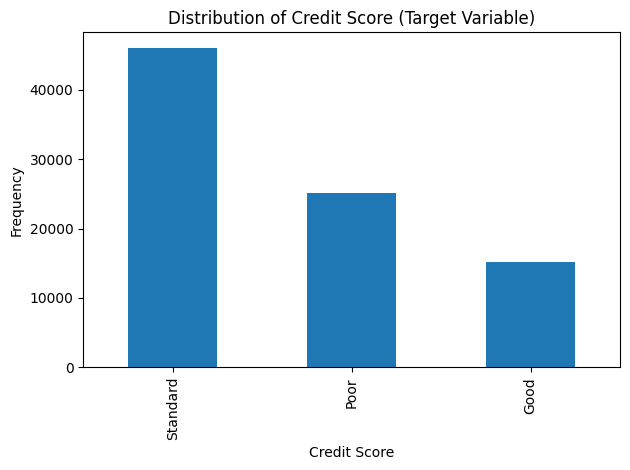

In [45]:
counts = data['Credit_Score'].value_counts()
counts.plot(kind='bar')
plt.title("Distribution of Credit Score (Target Variable)")
plt.xlabel("Credit Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

These classes certainly are not perfectly balanced, but it seems plausible to have more occurances in the "Standard" category than "Poor" or "Good". I think the current distribution is accpetable, but if we get to the testing phase of the project and the confusion matrix shows poor performance in predicting "Poor" or "Good", then we can return to this step and find ways to create more balance between the classes.

#### Data cleaning conclusion/discussion

The data cleaning process is so important. In this project it did not come without its struggles though. I think the most important take away I had was that the order in which data cleaning tasks occur really matters. I wanted to drop missing values first, but I couldn't properly identify missing values when the columns did not yet have the correct data types. I had to rearrange those steps so they could be executed properly.

I also had to make tough decisions about when to drop columns or rows with missing values, or choose to impute them, and what method I would use to impute them. I settled on using the median value for any missing values I didn't drop, since the number of missing values was relatively small.

Also worth noting is a column contained list of values, which I broke up into multiple boolean columns. This will be particuarly useful when model training begins, since the model will better understand multiple boolean features, rather than a single feature containing a list.

Overall, data cleaning was much needed for this dataset, and a key part of this project.

### Exploratory Data Analysis (20 pts)

*Rubric: Does it include clear explanations on how and why an analysis (EDA) is performed? Does it have proper visualizations? Does it have proper analysis? (e.g., histogram, correlation matrix, feature importance (if possible) etc.) Does it have conclusions or discussions? (e.g., the EDA summary, findings, discussing
foreseen difficulties and/or analysis strategy)*

*In addition to simple plots, the author included at least two of the following (or similar): good analysis and conclusions/discussions, correlation matrix with analysis, extra EDA (e.g.
statistical tests).*

I already began exploring the data as I went through the data cleaning process above, but now we can really dig into things before moving on to modeling.

After dropping many values in the data cleaning process, what shape are we left with for the dataset?

In [46]:
data.shape

(86283, 30)

Let's review some summary statistics:

In [47]:
data.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,86283.000000,8.628300e+04,86283.000000,86283.000000,86283.000000,86283.000000,86283.000000,86283.00000,86283.0,86283.0,86283.0,86283.000000,86283.000000,86283.000000,86283.000000,86283.000000,8.628300e+04
mean,33.308404,1.759535e+05,4023.032887,17.012227,22.382578,73.203354,7.115944,21.17890,30.171459,10.402873,27.561988,1432.027972,32.283968,18.370171,1386.839490,609.829783,-3.090605e+22
std,10.799769,1.429196e+06,2956.515900,117.152143,128.383578,469.678916,59.941974,14.87276,219.922762,6.734738,192.105929,1157.850169,5.113831,7.917236,8237.102946,1987.873563,3.209545e+24
min,14.000000,7.005930e+03,303.645417,0.000000,0.000000,1.000000,0.000000,-5.00000,0.0,-6.48,0.0,0.230000,20.000000,0.083333,0.000000,0.000000,-3.333333e+26
25%,24.000000,1.941965e+04,1790.189583,4.000000,4.000000,8.000000,2.000000,10.00000,9.0,5.455,3.0,566.980000,28.057156,12.750000,30.473954,76.813649,2.713355e+02
50%,33.000000,3.748298e+04,3093.745000,6.000000,6.000000,14.000000,3.000000,18.00000,14.0,9.4,6.0,1170.520000,32.299490,18.250000,69.411538,135.925682,3.364493e+02
75%,42.000000,7.263748e+04,5369.570000,7.000000,7.000000,20.000000,5.000000,28.00000,18.0,14.74,9.0,1961.730000,36.502252,24.250000,161.992218,254.525644,4.622598e+02
max,118.000000,2.419806e+07,15204.633333,1798.000000,1499.000000,5797.000000,1496.000000,67.00000,4397.0,36.29,2597.0,4998.070000,50.000000,33.666667,82331.000000,10000.000000,1.602041e+03


Because of our data cleaning, we removed over 8,000 out of the 100,000 rows we started with, but I think this will be beneficial, since those rows contained data that didn't make sense.

When we look at the data description table above, the values for our numerical features make sense thanks the data cleaning process I implemented.

Next, let's examine the correlation between features:

<Axes: >

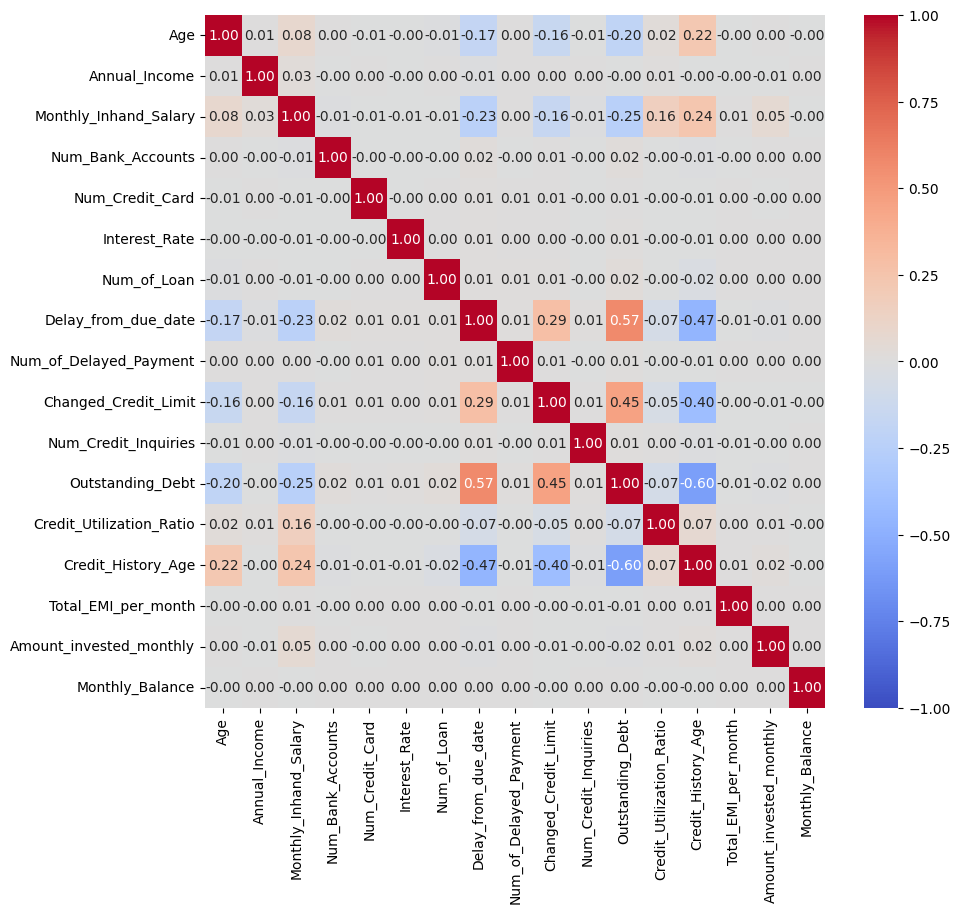

In [48]:
plt.figure(figsize=(10, 9))
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

Interestingly, many of the features we have here are not strongly correlated with each other. Hopefully, together they provide a strong indicator of someone's credit score. However, there are a few interesting correlations to note:

*   The strongest correlation (-0.6) is between the amount of debt someone has remaining (Outstanding_Debt) and the length of their credit history (Credit_History_Age)
*   It also appears that the more outstanding debt you have, the more likely you are to pay late (Outstanding_Debt and Delay_from_due_date have a correlation of 0.57)
*   Age and Monthly_Inhand_Salary also have notable correlations with many variables related to credit.

Based on some of these correlations, let's see if these variables are correlated to the target variable (Credit_Score) with some histograms.

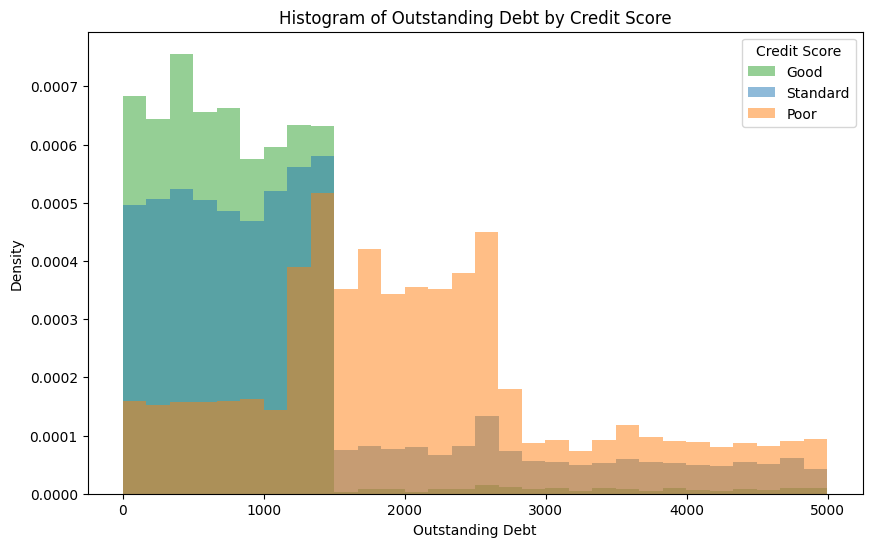

In [49]:
plt.figure(figsize=(10, 6))

classes = data['Credit_Score'].unique()
custom_colors = ['tab:green', 'tab:blue', 'tab:orange']
for cls, color in zip(classes, custom_colors):
    subset = data[data['Credit_Score'] == cls]
    plt.hist(subset['Outstanding_Debt'], bins=30, alpha=0.5, label=str(cls), density=True, color=color)

plt.xlabel('Outstanding Debt')
plt.ylabel('Density')
plt.title('Histogram of Outstanding Debt by Credit Score')
plt.legend(title='Credit Score')
plt.show()

We can see that those with more outstanding debt are more likely to have a poor credit score. This is a pattern that the model might be able to pick up on the better predict whether or not someone has a poor credit score.

Another interesting variable is Delay_from_due_date:

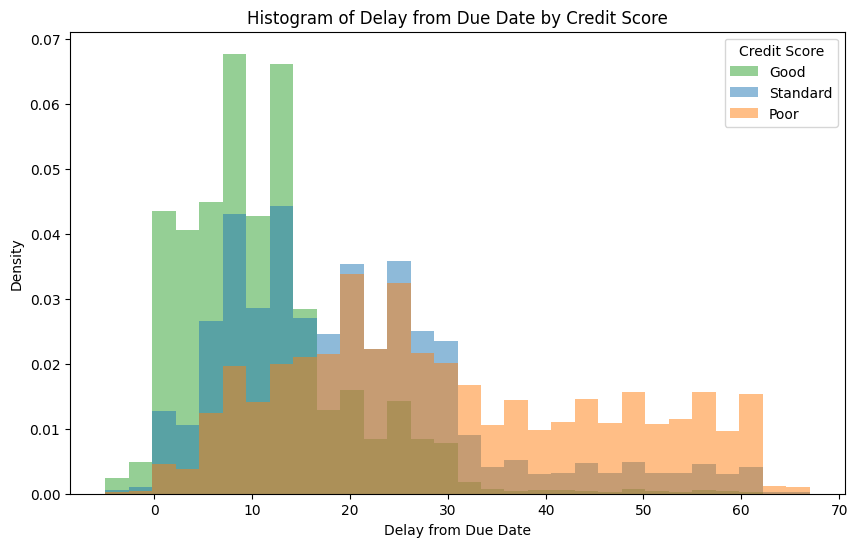

In [50]:
plt.figure(figsize=(10, 6))

classes = data['Credit_Score'].unique()
custom_colors = ['tab:green', 'tab:blue', 'tab:orange']
for cls, color in zip(classes, custom_colors):
    subset = data[data['Credit_Score'] == cls]
    plt.hist(subset['Delay_from_due_date'], bins=30, alpha=0.5, label=str(cls), density=True, color=color)

plt.xlabel('Delay from Due Date')
plt.ylabel('Density')
plt.title('Histogram of Delay from Due Date by Credit Score')
plt.legend(title='Credit Score')
plt.show()

Delay from due date tells us how late people made their lone payment relative to the due date. The histogram shows that those with good credit scores are more likely to make their payment sooner than those with a poor credit score. This is another indicator that the models should be able to use to help predict someone's credit score.

Let's also take a look at Monthly_Inhand_Salary:

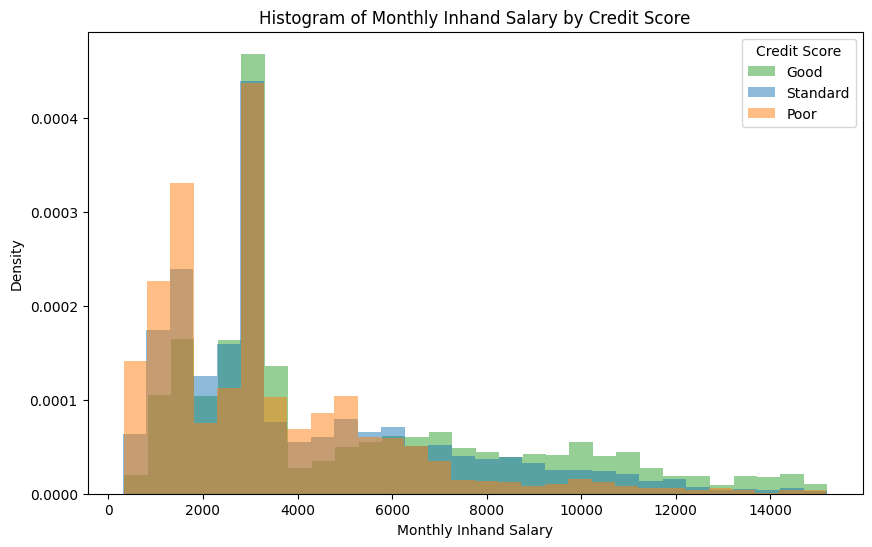

In [51]:
plt.figure(figsize=(10, 6))

classes = data['Credit_Score'].unique()
custom_colors = ['tab:green', 'tab:blue', 'tab:orange']
for cls, color in zip(classes, custom_colors):
    subset = data[data['Credit_Score'] == cls]
    plt.hist(subset['Monthly_Inhand_Salary'], bins=30, alpha=0.5, label=str(cls), density=True, color=color)

plt.xlabel('Monthly Inhand Salary')
plt.ylabel('Density')
plt.title('Histogram of Monthly Inhand Salary by Credit Score')
plt.legend(title='Credit Score')
plt.show()

Monthly Inhand Salary tells us how much money the person is bringing home each month. This feature is not as discriminate between the three categories, which we saw in the previous histograms. However, there is some indicaton that those with good credit scores tend to bring home slightly more money each month. The models may be able to use this to improve its predictions.

We can also use statistical tests to examine the relationship between categorical features and our target variable.

In the code chunk below, I performed a chi-square test between Occupation and Credit Score. The p-value is well below any reasonable alpha. This suggests a statistically significant association between occupation and credit score that the models can use.

In [52]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab(data['Occupation'], data['Credit_Score'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", pd.DataFrame(expected,
      index=contingency.index,
      columns=contingency.columns))

Chi-square statistic: 160.2424978775104
p-value: 1.7135704402129567e-20
Degrees of freedom: 28
Expected frequencies:
 Credit_Score          Good         Poor     Standard
Occupation                                          
Accountant     1025.601057  1705.471808  3116.927135
Architect      1031.213101  1714.804075  3133.982824
Developer      1005.257397  1671.642340  3055.100263
Doctor          989.999652  1646.270239  3008.730109
Engineer       1026.828692  1707.513241  3120.658067
Entrepreneur   1007.537290  1675.433573  3062.029137
Journalist      991.578040  1648.894939  3013.527022
Lawyer         1071.198915  1781.296478  3255.504607
Manager         975.268037  1621.773038  2963.958926
Mechanic       1024.548799  1703.722008  3113.729193
Media_Manager  1006.660408  1673.975407  3059.364185
Musician        966.148465  1606.608104  2936.243431
Scientist      1028.582455  1710.429575  3125.987970
Teacher        1015.604603  1688.848707  3086.546689
Writer          965.973089  1606.3

We can conduct a similar chi-square test between Payment_Behaviour and Credit_Score. Again, this test has an extremley small p-value, suggesting there is a relationship between payment behavior and credit score. This is promising, showing that the features in the dataset are predictive of the target variable.

In [53]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab(data['Payment_Behaviour'], data['Credit_Score'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", pd.DataFrame(expected,
      index=contingency.index,
      columns=contingency.columns))

Chi-square statistic: 1202.7084150152234
p-value: 4.5214373219341013e-250
Degrees of freedom: 12
Expected frequencies:
 Credit_Score                             Good         Poor      Standard
Payment_Behaviour                                                       
High_spent_Large_value_payments   2067.512117  3438.065517   6283.422366
High_spent_Medium_value_payments  2650.638573  4407.746393   8055.615034
High_spent_Small_value_payments   1713.953340  2850.132691   5208.913969
Low_spent_Large_value_payments    1576.458259  2621.492148   4791.049593
Low_spent_Medium_value_payments   2095.747714  3485.018486   6369.233800
Low_spent_Small_value_payments    3877.396335  6447.721649  11783.882016
Unknown                           1150.293662  1912.823117   3495.883221


#### Exploratory data analysis conclusion/discussion

I would say my exploratory data analysis really began during the data cleaning phase of the project. I performed an in-depth look at the values in each of the features in order to properly clean them. However, I was able to extend that anaylsis in this section as well.

I really wanted to focus my attention on the relationship between the different features and the target variable. However, I got first-hand experience that examine such relationships differs based on whether the variables are discrete or continuous. For continuous features, I was able to use correlation metrics and histograms, but for discrete features, I relied on chi-square tests.

I feel very confident after cleaning and exploring this dataset that I'll be able to create some skillful models that can predict credit scores.

### Models (25 pts)

*Rubric: Some questions to consider: Is the choice of model(s) appropriate for
the problem? Is the author aware of whether interaction/collinearity between features can be a problem for the choice of the model? Does the author properly treat if there is interaction or collinearity (e.g., linear regression)? Or does the author confirm that there is no such effect with the choice of the model? Did the author use multiple (appropriate) models? Did the author investigate which features are important by looking at feature rankings or importance from the model? (Not by judgment- which we already covered in the
EDA category) Did the author use techniques to reduce overfitting or data imbalance? Did the author use new techniques/models we didn't cover in the class?*

*At least three of the following: addresses multilinear regression/collinearity, feature engineering, multiple ML models, hyperparameter tuning, regularization or other training techniques such as cross validation, oversampling/undersampling/SMOTE or similar for managing data imbalance, uses models not
covered in class*

Now that we're at the model building step, I need to make sure the categorical features in the dataset are in numeric format, either throguh one-hot encoding or label encoding. I'm wary of one-hot encoding the remaining categorical features, since that would significantly increase the dimensionality of the dataset.

While not as ideal, I'll opt to label encode them. This way, the model can take advantage of these important variables, without increasing dimensionality.

(Uusally this step would take place in data cleaning, but I wanted to complete my exploration of these features in the EDA section before replacing these meaningful categorical values with numeric labels)

In [54]:
categorical_cols = data.select_dtypes(include='string[python]').columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

Before diving in, the first thing I need to do is split the data into training and testing sets, so that I can fairly assess the accuracy of the models I'm about to build.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Credit_Score']),
    data['Credit_Score'],
    test_size=0.2,   # 80/20 train/test split
    random_state=10
)

I'm going to attempt to **compare multiple ML models** in this section. I will create 5 different models and compare their performance in the next section. These models are common and well-known for their skill in classification tasks.
* Logistic regression (fits a logistic curve to make predictions)
* Random forest (an ensemble of decision trees)
* XGBoost (a gradient-boosted ensemble of shallow decision trees)
* Support vector machine (draws decision boundaries between classes)
* Naive Bayes (computes conditional probabilities to make predictions)

It's worth noting that we briefly touched on advanced tree ML algorithms like **XGBoost** in lectures, but it was not covered in-depth. We also did not cover **Naive Bayes** in this class either. I'll be using this project as an opportunity to **work with models not covered in class**.

In [56]:
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()
svc = SVC()
nb = GaussianNB()

Next, we'll fit these models to the training data.

In [57]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
svc.fit(X_train, y_train)
nb.fit(X_train, y_train)

GaussianNB()

Since we're using logistic regression, I want to make sure we're avoiding issues with **multicolinearity**. When two or more features in a regression model are not independent, they adversely affect the performance of the regression model. We can avoid this by dropping one of the variables, or choose an alterative dimensionality reduction technique.

I calculated the Variance Inflation Factor (VIF) for each feature below. When VIF is above 5, there is generally a concern about multicolinearity. When it is over 10, there is certainly mutlicolinearity that needs to be addressed.

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_numeric = X_train.copy().astype(float)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_numeric.values, i)
                   for i in range(X_train_numeric.shape[1])]
vif_data

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Feature,VIF
0,Age,0.095043
1,Occupation,0.277138
2,Annual_Income,0.984904
3,Monthly_Inhand_Salary,0.350158
4,Num_Bank_Accounts,0.979495
5,Num_Credit_Card,0.970457
6,Interest_Rate,0.976369
7,Num_of_Loan,0.986031
8,Delay_from_due_date,0.329954
9,Num_of_Delayed_Payment,0.981630


Based on the VIF shown above, the highest VIF for any feature is just over 1, which is not a cause for concern. This suggests **little to no multicolinearity** should be present in the logistic regression model.

It is also worth noting that we can better understand **feature importance**, particularly for the random forest model. The random forest is sklearn makes it very easy to examine feature importance. Here's a plot of the importances:

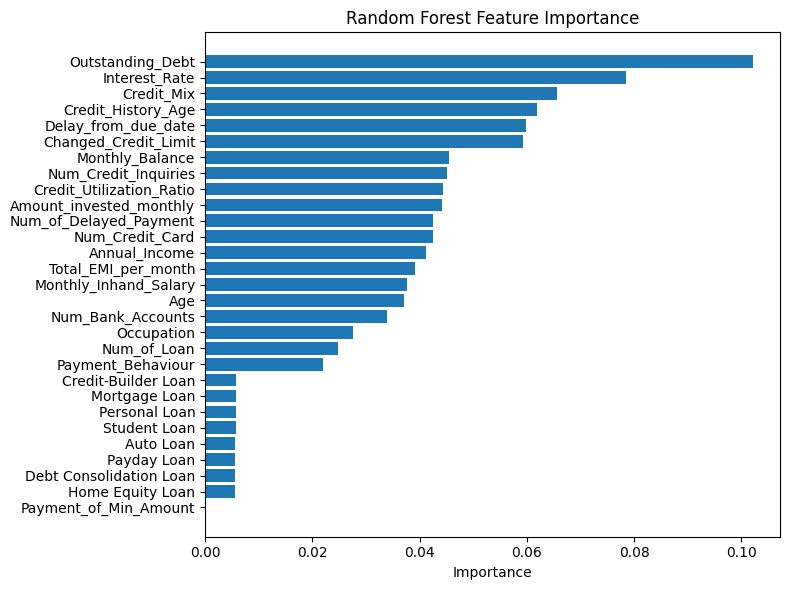

In [59]:
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

By far the most important feature for the random forest model to predict credit score is the amount of outstanding debt. This certainly makes sense, as those with more debt are more likely to have a worse credit score.

Similarly, the second-leading feature was interest rate. Those with higher interest rates have to pay more money back to leaders, which can make it more difficult for people to make payments, and more likely to have a lower credit score.

Towards the bottom of the plot, we see the boolean features I created for the various types of loan people have. It doesn't seem like those ended up being very important.

I'm somewhat surprised that payment of the minimum amount wasn't more important for credit score. The model seems to suggest that the overall amount of debt is most important.

### Results and Analysis (25 pts)

*Rubric: Some questions to consider: Does it have a summary of results and
analysis? Does it have a proper visualization? (E.g., tables, graphs/plots, heat maps, statistics summary with interpretation, etc.) Does it use different kinds of evaluation metrics properly? (E.g., if your data is imbalanced, there are other metrics (F1, ROC, or AUC) that are better than mere accuracy). Also, does it explain why they chose the metric? Does it iterate the training and evaluation process and improve the performance? Does it address selecting features through the iteration process? Did the author compare the results from the multiple models and make appropriate comparisons?*

*Includes three of the following: good amount of visualizations or tries different evaluation metrics or iterates training/evaluating and improving performance or shows/discusses
model performance*

In the last section, I fitted 5 models to predict credit scores from the provided dataset. Now, we'll take a look at how those models perform on unseen data.

In [60]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "XGBoost": xgb,
    "Support Vector Machine": svc,
    "Naive Bayes": nb
}

evaluation = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    row = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0),
    }

    evaluation.append(row)

# Create comparison table
metrics_df = pd.DataFrame(evaluation)
metrics_df.set_index("Model")
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.292983,0.617100,0.292983,0.133272
1,Random Forest,0.786058,0.785324,0.786058,0.785486
2,XGBoost,0.751173,0.750893,0.751173,0.750825
3,Support Vector Machine,0.531031,0.281994,0.531031,0.368371
4,Naive Bayes,0.531031,0.281994,0.531031,0.368371


The table above shows **various evaluation metrics**: accuracy, precision, recall, and F1 score.

The first metric is one we're all used to looking at first: **accuracy**. This is the number of correct predictions out of the total number of predictions. We see that logistic regression struggled, while the two tree-based algorithms performed the best. The accuracy for the random forest and XGBoost models were just over 75%.

However, sometimes accuracy can be misleading, especially when we don't have the same number of training samples for each label in the classification task. We rely on metrics like **precision and recall** to tell us more about the model's performance predicting each of the labels. Similar to accruacy, the precision and recall are much better for the random forest and XGBoost models, and are generally lacking for the other models.

Finally, I also computed an **F1 score** for each of the models. This is basically a combination of the precision and recall. It's no suprise that the random forest and XGBoost models both perform best in this metric as well.

I want to dig depper into the model evaluation, so **I'll choose the best model, the random forest**, and go in-depth on how it performed.

Let's examine the full set of evaluation statistics for the random forest:

In [61]:
print(classification_report(y_test, rf.predict(X_test), target_names=['Good', 'Poor', 'Standard']))

              precision    recall  f1-score   support

        Good       0.74      0.69      0.71      3027
        Poor       0.79      0.80      0.79      5066
    Standard       0.80      0.81      0.81      9164

    accuracy                           0.79     17257
   macro avg       0.78      0.77      0.77     17257
weighted avg       0.79      0.79      0.79     17257



The summary statistics above break down the evaluation by label. Recall the graph from earlier showing that the dataset had the most samples labeled with a "standard" credit score, followed by "poor", and the fewest samples were labeled with a "good" credit score.

Often those differences can manifest in the model's ability to properly classify new samples. Precision, recall, and F-score are highest for the "standard" label. The model was able to better understand when to label a sample as "standard" since it saw more of those samples in the training process. Likewise, the "good" shows slightly worse precision, recall, and F1-scores becuase the model saw the fewest of those samples during training.

We can plot similar information using a **confusion matrix**, which allows us to look more closely at the number of correctly and incorrectly classified samples for each label in the test set.

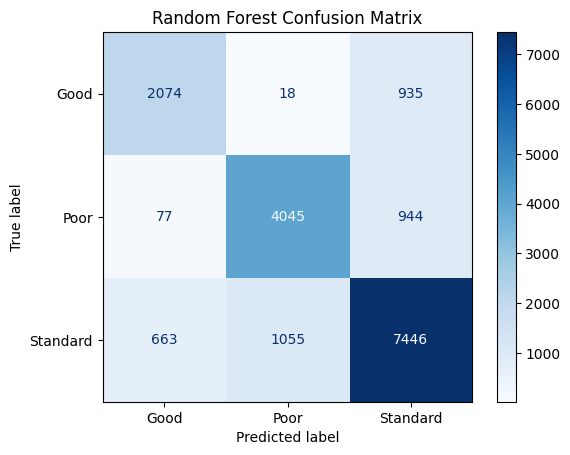

In [62]:
cm = confusion_matrix(y_test, rf.predict(X_test))
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good', 'Poor', 'Standard'])
cm_plot.plot(cmap=plt.cm.Blues)

plt.title("Random Forest Confusion Matrix")
plt.grid(False)
plt.show()

The confusion matrix gives us a great visual way to examine the performance of the model. The discrepancy between the sizes of the three categories in the dataset becomes much more obvious in this context. Overall, the model sees "standard" credit scores most often, and predicts it correctly quite often as well, hence the dark blue square in the bottom-right corner of the plot.

We see the brightest colors are along the diagonal of the matrix, which is what we always hope to see. Correct model predictions lie along the diagonal. We can also see that those not on the diagonal are not zero, and larger numbers indicate more room for improvement, since those represent incorrectly classified samples.

I also wanted to examine model performance through the ROC curve and AUC metric, but that can only be done for binary classification tasks. In order to perform that here, I would need to relabel the classes so that only 2 classes exist before moving forward with a ROC curve.

### Discussion and Conclusion (15 pts)

*Reflects on the successes and shortcomings of the project. Highlights implications of key results.*

*Includes all three of the following: discussion of learning and takeaways or discussion of why something didn't work or suggests ways to improve.*

Learning and key takeaways:

*   One of my goals for this project was to learn **what factors affect credit score** for my own personal benefit. The random forest's feature importances clearly showed that the **amount of outstanding debt** someone has was the best single predictor of their credit score. I'm already a debt-adverse person, but maintaining a good credit score is just **another reason to avoid debt**.
*   I learned that **data cleaning and exploration can sometimes be the most lengthly** portion of a data mining project. Coming into the project, I thought I would mainly focus on model building, evaluation, and improvement. But this dataset needed quite a bit of cleaning in order to train a model properly, and there's nothing wrong with spending more time and resouces on the cleaning and exploration phases of a data mining project.
*   I also **learned just how sensitive machine learning models can be to unbalanced classes** in classification tasks. I made sure to examine the balance of the classes during the data exploration, and noticed they weren't even, but also weren't way out of balance in my opinion. However, in the evaluation stage of the project, it was clear that the imbalance had a small impact on the performance of the model for each class.

What didn't work and why:

*   The **initial ordering of tasks in the data cleaning phase of the project did not work** at first. I wanted begin by dropping missing values first, but it wasn't possible to properly identify missing values when the columns did not yet have the correct data types. I had to rearrange those steps so they could be executed properly. Once I got the order right, I was able to get the data clean and in the right format for further exploration and modeling.
*   Even though I had already finished data cleaning, when I got to the model building phase of the project, I realized **I still had a few categorical variables**, and **most of scikit-learn's algorithms do not accept categorical variables**. Therefore, I had to back track momentarily, returning to the data cleaning phase to encode my categorical variables. I was able to do this and get my categorical variables to be useful in the model training and testing process.
*   I wanted to evaluate the accuracy of the random forest model with the various evaluation metrics, including the ROC curve and AUC. However, **ROC and AUC only works for binary classification** tasks. I would have needed to combine two classes after the fact, and focused on the ROC and AUC seperately for each of my three classes. A future iteration of this project could explore including that in the project.

Suggestions for improvement:

*   I selected the random forest model out of a set of five models, since it performed the best. However, an accuracy near 80% means there's nearly 20% room for improvement. I would want to **take a closer look at balancing the three labels**, whether through dropping samples from the majority classes, regularization methods, or other novel techniques.
*   This dataset had quite a few missing and erroneous values that led me to drop rows and columns in some cases. A future iteration of the project could **look more closely at where the lines should be drawn between imputing missing values, dropping affected rows, or dropping affected columns**. I felt my decisions regarding handling missing values in this project were neccessary, but also hand-wavy at best.
*   Future improvements to the project could focus more on **hyperparameters and tuning them to the appropriate values to future improve the accuracy** of the models. Random forest and XGBoost certainly showed the most potential in their performance in this project, but further hyperparameter tuning would likely further improve accuracy and other evaluation metrics as well.
